In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
! git clone https://github.com/DevinDeSilva/kinetics-i3d-Pytorch.git --branch master --single-branch
! pip install -q scikit-video
! pip install -q ffmpeg-python
! mv /content/kinetics-i3d-Pytorch/model /content/
! mv /content/kinetics-i3d-Pytorch/video_utils.py /content/video_utils.py

Cloning into 'kinetics-i3d-Pytorch'...
remote: Enumerating objects: 794, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 794 (delta 12), reused 0 (delta 0), pack-reused 772
Receiving objects: 100% (794/794), 446.72 MiB | 15.28 MiB/s, done.
Resolving deltas: 100% (83/83), done.
Updating files: 100% (58/58), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 62.3 MB/s eta 0:00:00


In [3]:
! pip install -q neptune
! git clone https://github.com/nipdep/HAR-ZSL-XAI.git --branch pd/PoseAE --single-branch
! mv /content/HAR-ZSL-XAI/src /content/

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.6/442.6 KB 23.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 KB 23.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.9/55.9 KB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.5/135.5 KB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.6/79.6 KB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 75.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.7/67.7 KB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 136.8/136.8 KB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 KB 8.2 MB/s eta 0:00:00
Cloning into 'HAR-ZSL-XAI'...
remote: Enumerating objects: 211, done.
remote: Counting objects: 100% (211/211), done.
remote: Compressing objects: 100% (122/122), done.
remote: Total 211 (delta 1

---

In [4]:

data_root = '/content/drive/MyDrive/22_FYP42 - Zero-shot Explainable HAR/Datasets/Consolidated/PAMPA2'

In [5]:
import os
import json
import numbers
import csv
import h5py
import skvideo
import skvideo.io 
import cv2
import gc

from glob import glob
from datetime import date, datetime
from tqdm.autonotebook import tqdm
from copy import deepcopy
from collections import defaultdict
import numpy as np 
import numpy.random as random
import pandas as pd
import pickle
from collections import defaultdict, OrderedDict
import neptune
import ffmpeg

import torch 
from torch import nn, Tensor
from torch.nn import functional as F
from torch.nn.modules import MultiheadAttention, Linear, Dropout, BatchNorm1d, TransformerEncoderLayer
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from torch.nn import MSELoss
import torchvision
from torchvision import datasets, transforms

from model.I3D_Pytorch import I3D
from video_utils import *

from src.datasets.data import PAMAP2Reader, PAMAP2ReaderV2
# from src.datasets.dataset import PAMAP2Dataset
from src.utils.analysis import action_evaluator
from src.datasets.utils import load_attribute

from src.models.loss import FeatureLoss, AttributeLoss
from src.utils.losses import *
from src.utils.analysis import action_evaluator

from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import cosine_similarity

# from src.running import train_step1, eval_step1

<ipython-input-5-c75bb4187df3>:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [6]:

from sklearn.manifold import TSNE
# from umap import UMAP

import matplotlib.pyplot as plt 
import seaborn as sns 
import plotly.express as px

In [7]:
# setup model configurations
config = {
    # general information
    "datetime": date.today(),
    "device": "gpu",
    "dataset": "PAMAP2", # "PAMAP2", "DaLiAc", "UTD"
    "Model": "BiLSTM",
    "sem-space": 'I3D',
    # model training configs
    "lr": 0.001,
    "imu_alpha": 0.0001,
    "n_epochs": 50,
    "batch_size": 32,
    # model configs
    "d_model": 128, 
    "num_heads": 2,
    "feat_size": 1024, # skel-AE hidden size and IMU-Anc output size
    "semantic_size": 1024,
    # dataset configs
    "window_size": 5.21, 
    "overlap": 4.21,
    "freq": 20,
    "seq_len": 50,  # skeleton seq. length
    "seen_split": 0.1,  
    "I3D":{
        "checkpoint":'kinetics-i3d-Pytorch/data/pytorch_checkpoints/rgb_imagenet.pkl',
        "VID_LOC":"/content/drive/MyDrive/22_FYP42 - Zero-shot Explainable HAR/Datasets/Consolidated/PAMPA2/Videos",
        "batch_size":8
    }
}

if config['device'] == 'cpu':
    device = "cpu"
else:
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [8]:
def save_model(model,model_name,unique_name,fold_id):
    PATH = f"{models_saves}/{model_name}"
    os.makedirs(PATH,exist_ok=True)
    torch.save({
        "n_epochs" : config["n_epochs"],
        "model_state_dict":model.state_dict(),
        "config": config
    }, f"{PATH}/{unique_name}_{fold_id}.pt")

model_iden = "fold"
notebook_iden = "SORTModel_feature"
models_saves = "model_saves"

In [9]:
IMU_data_path = data_root+'/IMU/Protocol/'
dataReader = PAMAP2ReaderV2(IMU_data_path)
actionList = dataReader.idToLabel

Reading file 1 of 14
Reading file 2 of 14
Reading file 3 of 14
Reading file 4 of 14
Reading file 5 of 14
Reading file 6 of 14
Reading file 7 of 14
Reading file 8 of 14
Reading file 9 of 14
Reading file 10 of 14
Reading file 11 of 14
Reading file 12 of 14
Reading file 13 of 14
Reading file 14 of 14


/content/src/datasets/data.py:1275: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.asarray(data), np.asarray(labels, dtype=int), np.array(collection)


In [10]:
gc.collect()
torch.cuda.empty_cache()

In [11]:
def read_vid_ffmpeg(file_loc,width=224,height=224,num_frames=90):
  out, _ = (
    ffmpeg
    .input(file_loc)
    .filter('select', 'lte(n,{})'.format(num_frames))
    .output('pipe:', format='rawvideo', pix_fmt='rgb24',s='{}x{}'.format(width, height))
    .run(capture_stdout=True)
  )
  video = (
      np
      .frombuffer(out, np.uint8)
      .reshape([-1, height, width, 3])
  )

  return video

class CollectedDataset(Dataset):
    def __init__(self, data_dir,transforms,all_vids = True,num_sel_vids = 8):
        self.data_dir = data_dir
        self.transforms = transforms
        self.num_sel_vids = num_sel_vids
        self.all_vids = all_vids
        self.gen_cls_map()
        self.__get_data()
        self.generate()

    def gen_cls_map(self):
      self.id2cls = {}
      self.cls2id = {}
      for i,fol in enumerate(os.listdir(self.data_dir)):
        self.id2cls[i] = fol
        self.cls2id[fol] = i
    
    def generate(self):
      self.__random_select(self.num_sel_vids)
      self.__load_vids()

    def __random_select(self,num_sel_vids):
      if self.all_vids:
        self.selected_indexes = np.arange(self.video_class.shape[0])
        return

      self.selected_indexes = []
      for id in np.unique(self.video_class):
        self.selected_indexes.append(np.random.choice(np.where(self.video_class == id)[0],size=num_sel_vids,replace=False))

      self.selected_indexes = np.sort(np.concatenate(self.selected_indexes))

    def __load_vids(self):
      if hasattr(self,"selected_video"):
        del self.selected_video

      if hasattr(self,"selected_class"):
        del self.selected_class
      
      gc.collect()
      torch.cuda.empty_cache()

      self.selected_video = []
      self.selected_class = self.video_class[self.selected_indexes]
      for apath in tqdm(self.vid_paths[self.selected_indexes],
                        desc="Loading Vids -> memory",total = len(self.selected_indexes)):
        vid = read_vid_ffmpeg(apath)
        vid = video_to_tensor(self.transforms(vid))
        
        if vid.shape[1] <90:
          vid = vid.repeat(1,2,1,1)

        vid = vid[:,0:90,:,:]
        self.selected_video.append(vid)
      
      self.selected_video = torch.stack(self.selected_video,dim=0).to(torch.float16)
      gc.collect()
      torch.cuda.empty_cache()
      
    def __get_data(self):
      vid_path = []
      vid_name = []
      vid_class = []
      for x in glob(f"{self.data_dir}/*/*.mp4"):
        path_parts = x.split(os.path.sep)
        vid_name.append(path_parts[-1].split(".")[0])
        vid_class.append(self.cls2id[path_parts[-2]])
        vid_path.append(x)

      self.vid_paths,self.video_name,self.video_class = np.asarray(vid_path),np.asarray(vid_name),np.asarray(vid_class)

    def __getitem__(self, index):
        """
        Args:
            index (int): Index

        Returns:
            tuple: (image, target) where target is class_index of the target class.
        """

        return self.selected_video[index], self.selected_class[index]

    def __len__(self):
        return len(self.selected_indexes)


In [12]:
class PAMAP2Dataset(Dataset):
    def __init__(self, data, actions, action_classes, seq_len=120):
        super(PAMAP2Dataset, self).__init__()
        self.data = torch.from_numpy(data)
        self.actions = actions
        self.seq_len = seq_len
        self.action_classes = action_classes
        # build action to id mapping dict
        self.n_action = len(self.actions)
        self.action2Id = dict(zip(action_classes, range(self.n_action)))

    def __getitem__(self, ind):
        x = self.data[ind, ...]
        target = self.actions[ind]
        y = torch.from_numpy(np.array([self.action2Id[target]]))
        # extraction semantic space generation skeleton sequences
        return x, y,target

    def __len__(self):
        return self.data.shape[0]

In [13]:
class IMUEncoder(nn.Module):
    def __init__(self, in_ft, d_model, ft_size, n_classes, num_heads=1, max_len=1024, dropout=0.1):
        super(IMUEncoder, self).__init__()
        self.in_ft = in_ft
        self.max_len = max_len
        self.d_model = d_model
        self.num_heads = num_heads
        self.ft_size = ft_size 
        self.n_classes = n_classes

        self.lstm = nn.LSTM(input_size=self.in_ft,
                            hidden_size=self.d_model,
                            num_layers=self.num_heads,
                            batch_first=True,
                            bidirectional=True)
        self.drop = nn.Dropout(p=0.1)
        self.act = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.fcLayer1 = nn.Linear(2*self.d_model, self.ft_size)
        # self.fcLayer2 = nn.Linear(self.ft_size, self.ft_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out_forward = out[:, self.max_len - 1, :self.d_model]
        out_reverse = out[:, 0, self.d_model:]
        out_reduced = torch.cat((out_forward, out_reverse), 1)
        out = self.drop(out_reduced)
        out = self.act(out)
        out = self.fcLayer1(out)
        out = self.sigmoid(out)
        # out = self.fcLayer2(out)
        return out

class CombinedModel(nn.Module):
  def __init__(self, imu_encoder:nn.Module,video_encoder:nn.Module, mode=400):
        super(CombinedModel, self).__init__()
        self.imu_encoder = imu_encoder
        self.video_encoder = video_encoder
        self.mode = mode
  
  def forward(self,x_imu):
    x_imu = self.imu_encoder(x_imu)
    return x_imu
    

In [14]:
def create_model(config,in_ft,seq_len,seen_classes):
  # build model
  vid_enc = I3D(input_channel=3)
  vid_enc.load_state_dict(torch.load(config["I3D"]["checkpoint"]))

  for param in vid_enc.features.parameters():
      param.requires_grad = False

  for param in vid_enc.features[16:].parameters():
      param.requires_grad = True

  imu_config = {
        'in_ft':in_ft, 
        'd_model':config['d_model'], 
        'num_heads':config['num_heads'], 
        'ft_size':config['feat_size'], 
        'max_len':seq_len, 
        'n_classes':len(seen_classes)
    }
  imu_enc = IMUEncoder(**imu_config)

  model = CombinedModel(imu_enc,vid_enc)

  return model

---

In [15]:
# run 5-fold running
fold_classes = [['watching TV', 'house cleaning', 'standing', 'ascending stairs'], ['walking', 'rope jumping', 'sitting', 'descending stairs'], ['playing soccer', 'lying', 'vacuum cleaning', 'computer work'], ['cycling', 'running', 'Nordic walking'], ['ironing', 'car driving', 'folding laundry']]

fold_cls_ids = [[actionList.index(i) for i in j] for j in fold_classes]

In [16]:

def shuffledTripletLoss(pred_feat, anchor_feat, y, bs=32, loss_fn=nn.TripletMarginLoss(margin=0.5, p=2, reduction='none')):
    neg_feat = torch.concat([anchor_feat[bs//2:, ...], anchor_feat[:bs//2, ...]], dim=0)
    pos_feat = anchor_feat

    neg_y = torch.concat([y[bs//2:], y[:bs//2]])
    y_mask = (y!=neg_y).long()

    output_arr = loss_fn(pred_feat, pos_feat, neg_feat)
    masked_arr = torch.multiply(output_arr, y_mask)

    output = masked_arr.mean()
    return output

def newLoss(y_pred, y, feat, loss_fn):
    mm_vec = torch.mm(y_pred, torch.transpose(feat, 0, 1))
    feat_norm = torch.norm(feat, p=2, dim=1)
    norm_vec = mm_vec/torch.unsqueeze(feat_norm, 0)
    softmax_vec = torch.softmax(norm_vec, dim=1)
    output = loss_fn(softmax_vec, y)
    return output

def loss_reconstruction_calc(y_pred, y_feat,y, loss_fn=shuffledTripletLoss):
    bat_size,feature_size = y_pred.size()
    loss = loss_fn(y_pred,y_feat,y,bs=bat_size)
    return loss

def predict_class(y_pred, feat):
    mm_vec = torch.mm(y_pred, torch.transpose(feat, 0, 1))
    feat_norm = torch.norm(feat, p=2, dim=1)
    norm_vec = mm_vec/torch.unsqueeze(feat_norm, 0)
    softmax_vec = torch.softmax(norm_vec, dim=1)
    pred = torch.argmax(softmax_vec, dim=-1)
    return pred

In [17]:
def semantic_space_generation_step(model,dataloader,dataset, mode=400):
  with tqdm(dataloader, unit="batch", desc="sematic space generation") as tepoch:
        features = []
        cls = []
        for batch in tepoch:
          X,label = batch
          X = X.to(torch.float32).to(device)
          feat = model(X)
          if mode == 400:
            feat = feat[1]
          elif mode == 1024:
            feat = feat[2]
          else:
            raise NotImplementedError()
          features.append(feat)
          cls.append(label)

        features = torch.concat(features,dim=0).cpu().detach().numpy()
        cls = torch.concat(cls,dim=0).numpy()


        mean_feat = []
        mean_cls = []
        mean_clsname = []
        for sel_cls in np.unique(cls):
          mean_feat.append(features[cls==sel_cls].mean(axis=0))
          mean_cls.append(sel_cls)
          mean_clsname.append(dataset.id2cls[sel_cls])

        cls = np.asarray(mean_cls)
        clsname = np.asarray(mean_clsname)
        features = np.asarray(mean_feat)
        return clsname, features

In [18]:
def train_step(model, dataloader, dataset:PAMAP2Dataset, sem_space,optimizer, loss_module, device, class_names, phase='train', l2_reg=False, loss_alpha=0.7):
    model = model.train()
    epoch_loss = 0  # total loss of epoch
    total_samples = 0  # total samples in epoch
    random_selected_feat = sem_space[dataset.action_classes,...]

    with tqdm(dataloader, unit="batch", desc=phase) as tepoch:
        for batch in tepoch:
            X, targets, orig_cls_id = batch
            X = X.float().to(device)
            
            target_feat = sem_space[orig_cls_id,...]
            target_feat = target_feat.float()
            targets = targets.long().to(device)

            # Zero gradients, perform a backward pass, and update the weights.
            optimizer.zero_grad()
            # forward track history if only in train
            with torch.set_grad_enabled(phase == 'train'):
            # with autocast():
                feat_output = model(X)
                class_loss = newLoss(feat_output, targets.squeeze(), random_selected_feat, loss_fn=loss_module['class'] )
                feat_loss = loss_reconstruction_calc(feat_output, target_feat,targets.squeeze(), loss_fn=loss_module["feature"])

            #loss = cross_entropy_loss
            loss = feat_loss + loss_alpha*class_loss
            class_output = predict_class(feat_output, random_selected_feat)

            if phase == 'train':
                loss.backward()
                optimizer.step()

            metrics = {"loss": loss.item()}
            with torch.no_grad():
                total_samples += len(targets)
                epoch_loss += loss.item()  # add total loss of batch

            # convert feature vector into action class using cosine
            pred_class = class_output.cpu().detach().numpy()
            metrics["accuracy"] = accuracy_score(y_true=targets.cpu().detach().numpy(), y_pred=pred_class)
            tepoch.set_postfix(metrics)

    epoch_loss = epoch_loss / total_samples  # average loss per sample for whole epoch
    return metrics

In [19]:
def eval_step(model, dataloader, dataset, sem_space, loss_module, device, class_names,  phase='seen', l2_reg=False, print_report=False, show_plot=False, loss_alpha=0.7):
    model = model.eval()
    epoch_loss = 0  # total loss of epoch
    total_samples = 0  # total samples in epoch
    random_selected_feat = sem_space[dataset.action_classes,...]
    per_batch = {'target_masks': [], 'targets': [], 'predictions': [], 'metrics': [], 'IDs': []}
    metrics = {"samples": 0, "loss": 0, "feat. loss": 0, "classi. loss": 0}

    with tqdm(dataloader, unit="batch", desc=phase) as tepoch:
        for batch in tepoch:
            X, targets, orig_cls_id = batch
            X = X.float().to(device)
            
            target_feat = sem_space[orig_cls_id,...]
            target_feat = target_feat.float()
            targets = targets.long().to(device)

            # forward track history if only in train
            with torch.set_grad_enabled(phase == 'train'):
            # with autocast():
                feat_output = model(X)
                class_loss = newLoss(feat_output, targets.squeeze(), random_selected_feat, loss_fn=loss_module['class'] )
                feat_loss = loss_reconstruction_calc(feat_output, target_feat,targets.squeeze(), loss_fn=loss_module["feature"])
            
            loss = feat_loss + loss_alpha*class_loss
            class_output = predict_class(feat_output, random_selected_feat)

            # convert feature vector into action class using cosine
            if phase == 'seen':
                pred_action = class_output
            else:
                #feat_numpy = torch.sigmoid(feat_output.cpu().detach())
                #action_probs = cosine_similarity(feat_numpy, target_feat_met)
                pred_action = class_output

            with torch.no_grad():
                metrics['samples'] += len(targets)
                metrics['loss'] += loss.item()  # add total loss of batch
                metrics['feat. loss'] += feat_loss.item()
                metrics['classi. loss'] += class_loss.item()

            per_batch['targets'].append(targets.cpu().numpy())
            per_batch['predictions'].append(pred_action.cpu().numpy())
            per_batch['metrics'].append([loss.cpu().numpy()])

            tepoch.set_postfix({"loss": loss.item()})

    all_preds = np.concatenate(per_batch["predictions"])
    all_targets = np.concatenate(per_batch["targets"])
    metrics_dict = action_evaluator(y_pred=all_preds, y_true=all_targets[:, 0], class_names=class_names, print_report=print_report, show_plot=show_plot)
    metrics_dict.update(metrics)
    return metrics_dict

In [20]:
def plot_curves(df):
    df['loss'] = df['loss']/df['samples']
    df['feat. loss'] = df['feat. loss']/df['samples']
    df['classi. loss'] = df['classi. loss']/df['samples']
    
    fig, axs = plt.subplots(nrows=4, figsize=(15, 15))
    sns.lineplot(data=df, x='epoch', y='loss', hue='phase', marker='o', ax=axs[2]).set(title="Loss")
    sns.lineplot(data=df, x='epoch', y='feat. loss', hue='phase', marker='o', ax=axs[0]).set(title="Feature Loss")
    sns.lineplot(data=df, x='epoch', y='classi. loss', hue='phase', marker='o', ax=axs[1]).set(title="Classification Loss")
    sns.lineplot(data=df, x='epoch', y='accuracy', hue='phase', marker='o', ax=axs[3]).set(title="Accuracy")

In [21]:
def log(fold, phase, metrics):
    for m, v in metrics.items():
        if fold == 'global':
            run[f'global/{m}'].log(v)
        else:
            run[f"Fold-{fold}/{phase}/{m}"].log(v) 

In [22]:
run = neptune.init_run(
    project="FYP-Group22/ICANN-Logs",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJkNWJjMDdhNC05NWY5LTQwNWQtYTQyNi0zNjNmYmYwZDg3M2YifQ==",
)  # your credentials

<ipython-input-22-0fd58e113600>:1: NeptuneWarning: To avoid unintended consumption of logging hours during interactive sessions, the following monitoring options are disabled unless set to 'True' when initializing the run: 'capture_stdout', 'capture_stderr', and 'capture_hardware_metrics'.
  run = neptune.init_run(


https://app.neptune.ai/FYP-Group22/ICANN-Logs/e/IC-87


In [23]:
gc.collect()
torch.cuda.empty_cache()

<ipython-input-24-4799c1479a01>:1: NeptuneUnsupportedType: You're attempting to log a type that is not directly supported by Neptune (<class 'datetime.date'>).
        Convert the value to a supported type, such as a string or float, or use stringify_unsupported(obj)
        for dictionaries or collections that contain unsupported values.
        For more, see https://docs.neptune.ai/help/value_of_unsupported_type
  run['parameters'] = config


Generate Video Data ...


Loading Vids -> memory:   0%|          | 0/177 [00:00<?, ?it/s]

/content/video_utils.py:65: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  return torch.from_numpy(pic.transpose([3,0,1,2]))


================ Fold-0 ================
Unseen Classes : ['watching TV', 'house cleaning', 'standing', 'ascending stairs']
seen classes >  [0, 1, 3, 4, 5, 6, 8, 9, 11, 12, 13, 14, 16, 17]
unseen classes >  [7, 15, 2, 10]
Initiate IMU datasets ...


Training Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/588 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.761



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/588 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.817



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/588 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.764



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/588 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.754



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/588 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.801



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/588 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.877



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/588 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.742



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/588 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.884



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/588 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.895



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/588 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.829



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/588 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.919



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/588 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.878



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/588 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.900



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/588 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.888



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/588 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.913



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/588 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.906



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/588 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.914



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/588 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.820



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/588 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.854



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/588 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.901



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/588 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.894



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/588 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.919



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/588 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.944



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/588 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.934



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/588 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.920



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/588 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.884



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/588 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.937



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/588 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.951



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/588 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.916



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/588 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.915



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/588 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.922



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/588 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.890



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/588 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.946



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/588 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.927



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/588 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.895



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/588 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.917



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/588 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.934



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/588 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.957



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/588 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.875



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/588 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.927



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/588 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.922



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/588 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.917



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/588 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.924



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/588 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.947



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/588 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.937



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/588 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.902



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/588 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.939



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/588 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.925



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/588 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.949



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/588 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.956



unseen:   0%|          | 0/175 [00:00<?, ?batch/s]

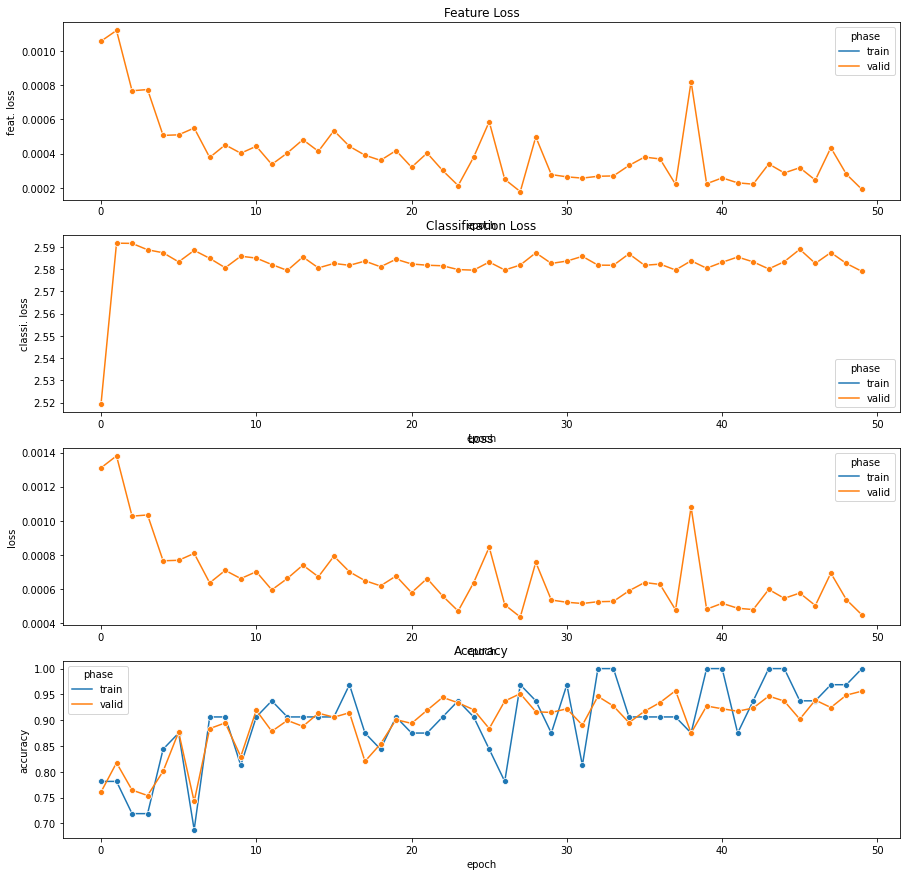

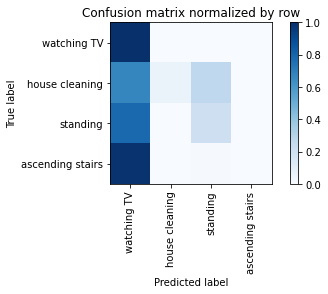

Overall accuracy: 0.241

                   precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

        standing       0.442      0.214      0.289      0.331       1853|	 watching TV: 0.785,	house cleaning: 0.001,	
  house cleaning       0.968      0.066      0.123      0.328       1838|	 watching TV: 0.668,	standing: 0.266,	
ascending stairs       0.000      0.000      0.000      0.193       1080|	 watching TV: 0.987,	standing: 0.011,	house cleaning: 0.002,	
     watching TV       0.181      1.000      0.307      0.148        829|	 ascending stairs: 0.000,	standing: 0.000,	

----------------------------------------------------------------------------------------------------
     avg / total       0.491      0.241      0.181        1.0       5600|	      

{'accuracy': 0.2405357142857143, 'precision': 0.39780413688467514, 'recall': 0.32001989832680233, 'f1': 0.1796498188462029, 'samples': 5600, 'loss': 45.61441761255264, 'feat. loss': 44.84705801308155, 'classi. los

Training Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/590 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.635



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/590 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.713



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/590 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.758



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/590 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.803



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/590 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.838



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/590 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.842



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/590 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.861



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/590 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.881



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/590 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.865



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/590 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.876



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/590 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.904



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/590 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.894



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/590 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.899



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/590 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.905



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/590 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.896



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/590 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.903



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/590 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.885



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/590 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.894



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/590 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.905



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/590 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.902



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/590 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.891



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/590 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.900



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/590 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.903



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/590 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.914



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/590 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.885



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/590 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.917



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/590 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.904



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/590 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.912



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/590 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.903



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/590 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.917



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/590 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.920



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/590 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.921



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/590 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.921



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/590 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.926



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/590 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.893



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/590 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.925



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/590 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.929



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/590 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.922



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/590 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.889



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/590 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.915



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/590 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.938



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/590 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.915



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/590 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.906



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/590 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.930



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/590 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.927



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/590 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.894



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/590 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.911



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/590 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.918



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/590 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.918



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/590 [00:00<?, ?batch/s]

seen:   0%|          | 0/65 [00:00<?, ?batch/s]

Overall accuracy: 0.918



unseen:   0%|          | 0/173 [00:00<?, ?batch/s]

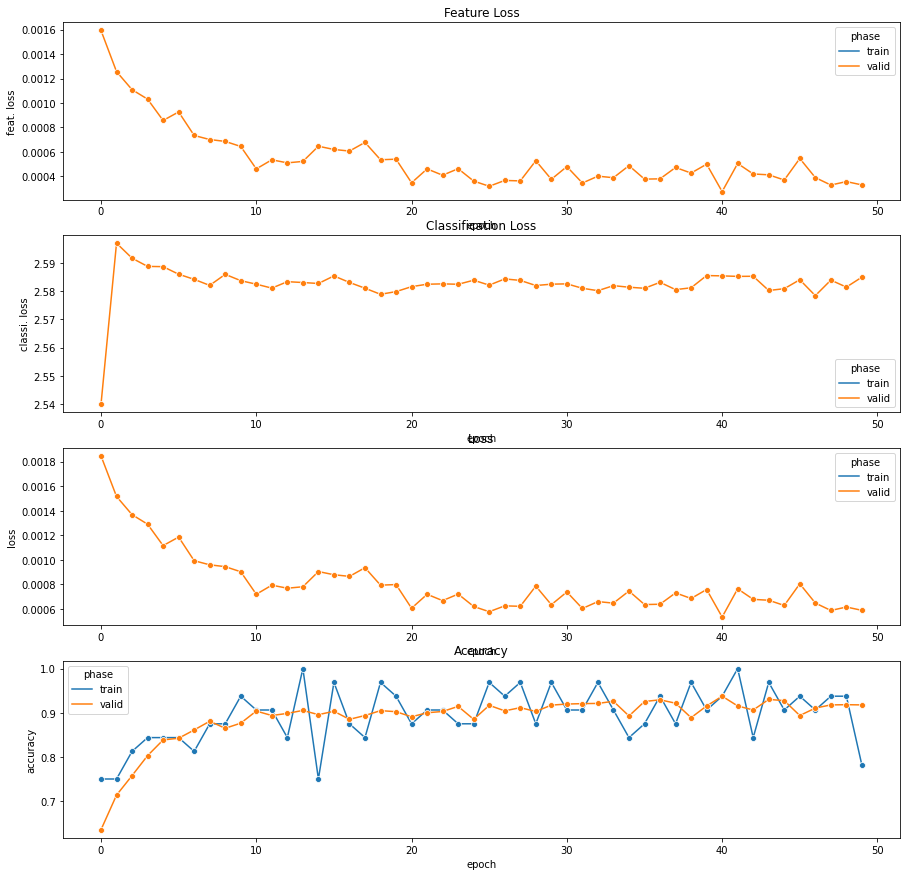

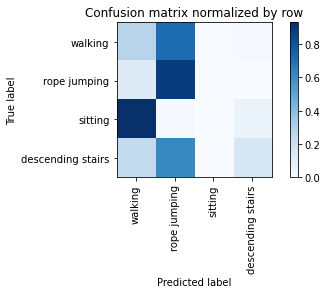

Overall accuracy: 0.215

                    precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

          walking       0.248      0.275      0.261      0.421       2332|	 rope jumping: 0.715,	descending stairs: 0.010,	
          sitting       0.000      0.000      0.000      0.324       1796|	 walking: 0.930,	descending stairs: 0.061,	rope jumping: 0.009,	
descending stairs       0.511      0.149      0.231      0.171        947|	 rope jumping: 0.614,	walking: 0.237,	
     rope jumping       0.152      0.883      0.260      0.083        461|	 walking: 0.115,	descending stairs: 0.002,	

----------------------------------------------------------------------------------------------------
      avg / total       0.204      0.215      0.171        1.0       5536|	      

{'accuracy': 0.21477601156069365, 'precision': 0.22773213984569612, 'recall': 0.3266564827761225, 'f1': 0.18776186855274632, 'samples': 5536, 'loss': 66.44889703392982, 'feat. loss': 65.68316188454628

Training Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/546 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

Overall accuracy: 0.710



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/546 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

Overall accuracy: 0.620



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/546 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

Overall accuracy: 0.669



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/546 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

Overall accuracy: 0.708



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/546 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

Overall accuracy: 0.797



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/546 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

Overall accuracy: 0.795



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/546 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

Overall accuracy: 0.835



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/546 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

Overall accuracy: 0.855



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/546 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

Overall accuracy: 0.892



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/546 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

Overall accuracy: 0.894



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/546 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

Overall accuracy: 0.806



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/546 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

Overall accuracy: 0.872



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/546 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

Overall accuracy: 0.858



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/546 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

Overall accuracy: 0.864



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/546 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

Overall accuracy: 0.882



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/546 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

Overall accuracy: 0.865



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/546 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

Overall accuracy: 0.906



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/546 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

Overall accuracy: 0.891



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/546 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

Overall accuracy: 0.854



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/546 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

Overall accuracy: 0.914



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/546 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

Overall accuracy: 0.872



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/546 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

Overall accuracy: 0.909



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/546 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

Overall accuracy: 0.889



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/546 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

Overall accuracy: 0.877



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/546 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

Overall accuracy: 0.919



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/546 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

Overall accuracy: 0.905



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/546 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

Overall accuracy: 0.926



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/546 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

Overall accuracy: 0.836



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/546 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

Overall accuracy: 0.935



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/546 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

Overall accuracy: 0.846



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/546 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

Overall accuracy: 0.899



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/546 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

Overall accuracy: 0.935



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/546 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

Overall accuracy: 0.908



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/546 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

Overall accuracy: 0.896



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/546 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

Overall accuracy: 0.927



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/546 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

Overall accuracy: 0.931



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/546 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

Overall accuracy: 0.891



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/546 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

Overall accuracy: 0.919



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/546 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

Overall accuracy: 0.926



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/546 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

Overall accuracy: 0.945



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/546 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

Overall accuracy: 0.918



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/546 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

Overall accuracy: 0.915



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/546 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

Overall accuracy: 0.940



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/546 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

Overall accuracy: 0.924



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/546 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

Overall accuracy: 0.930



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/546 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

Overall accuracy: 0.935



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/546 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

Overall accuracy: 0.944



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/546 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

Overall accuracy: 0.939



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/546 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

Overall accuracy: 0.936



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/546 [00:00<?, ?batch/s]

seen:   0%|          | 0/60 [00:00<?, ?batch/s]

Overall accuracy: 0.937



unseen:   0%|          | 0/222 [00:00<?, ?batch/s]

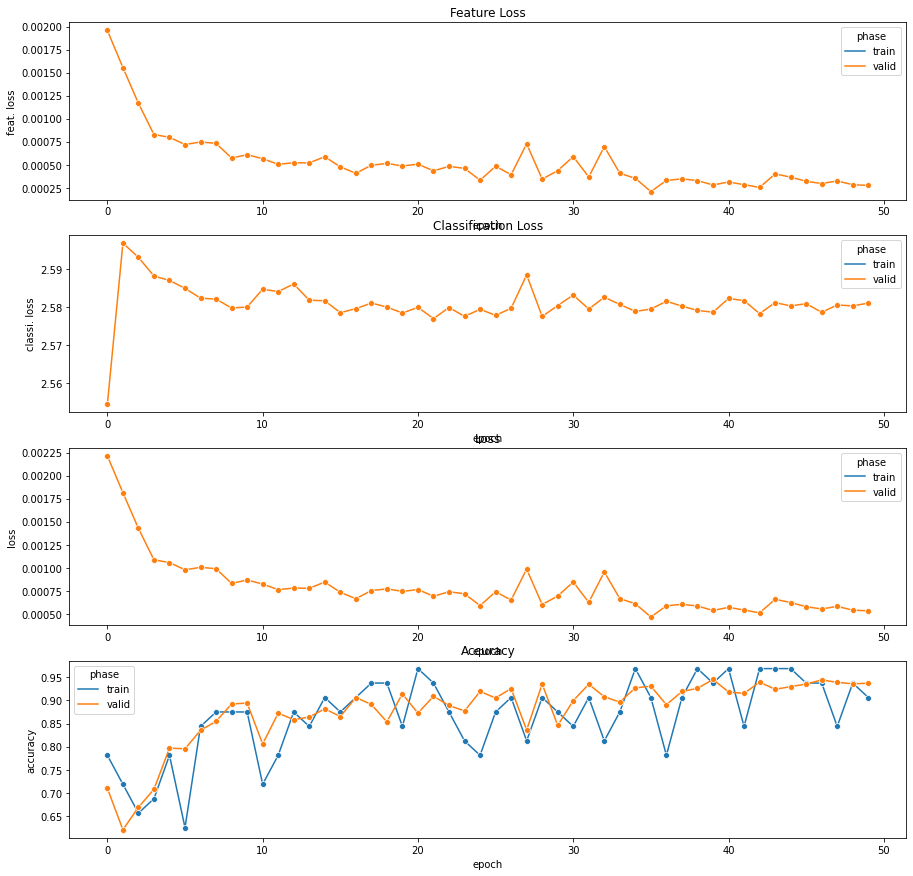

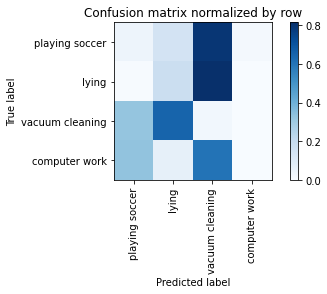

Overall accuracy: 0.056

                  precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

  computer work       0.071      0.000      0.001      0.432       3070|	 vacuum cleaning: 0.604,	playing soccer: 0.328,	lying: 0.067,	
          lying       0.197      0.180      0.188      0.264       1873|	 vacuum cleaning: 0.814,	playing soccer: 0.005,	
vacuum cleaning       0.011      0.023      0.015      0.240       1703|	 lying: 0.649,	playing soccer: 0.324,	
 playing soccer       0.011      0.039      0.018      0.064        458|	 vacuum cleaning: 0.795,	lying: 0.148,	

----------------------------------------------------------------------------------------------------
    avg / total       0.086      0.056      0.055        1.0       7104|	      

{'accuracy': 0.05588400900900901, 'precision': 0.07249078704027903, 'recall': 0.06089354044887004, 'f1': 0.05525559531602305, 'samples': 7104, 'loss': 76.27148127555847, 'feat. loss': 75.28609931468964, 'classi. loss':

Training Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/623 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

Overall accuracy: 0.619



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/623 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

Overall accuracy: 0.684



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/623 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

Overall accuracy: 0.678



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/623 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

Overall accuracy: 0.723



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/623 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

Overall accuracy: 0.742



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/623 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

Overall accuracy: 0.734



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/623 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

Overall accuracy: 0.731



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/623 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

Overall accuracy: 0.800



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/623 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

Overall accuracy: 0.761



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/623 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

Overall accuracy: 0.760



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/623 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

Overall accuracy: 0.836



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/623 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

Overall accuracy: 0.803



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/623 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

Overall accuracy: 0.864



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/623 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

Overall accuracy: 0.874



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/623 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

Overall accuracy: 0.802



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/623 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

Overall accuracy: 0.790



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/623 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

Overall accuracy: 0.866



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/623 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

Overall accuracy: 0.847



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/623 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

Overall accuracy: 0.792



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/623 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

Overall accuracy: 0.864



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/623 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

Overall accuracy: 0.827



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/623 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

Overall accuracy: 0.852



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/623 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

Overall accuracy: 0.859



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/623 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

Overall accuracy: 0.856



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/623 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

Overall accuracy: 0.855



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/623 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

Overall accuracy: 0.799



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/623 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

Overall accuracy: 0.896



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/623 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

Overall accuracy: 0.795



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/623 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

Overall accuracy: 0.835



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/623 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

Overall accuracy: 0.864



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/623 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

Overall accuracy: 0.911



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/623 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

Overall accuracy: 0.861



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/623 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

Overall accuracy: 0.910



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/623 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

Overall accuracy: 0.878



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/623 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

Overall accuracy: 0.895



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/623 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

Overall accuracy: 0.869



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/623 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

Overall accuracy: 0.869



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/623 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

Overall accuracy: 0.896



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/623 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

Overall accuracy: 0.876



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/623 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

Overall accuracy: 0.901



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/623 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

Overall accuracy: 0.878



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/623 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

Overall accuracy: 0.923



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/623 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

Overall accuracy: 0.865



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/623 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

Overall accuracy: 0.808



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/623 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

Overall accuracy: 0.870



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/623 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

Overall accuracy: 0.880



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/623 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

Overall accuracy: 0.854



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/623 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

Overall accuracy: 0.890



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/623 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

Overall accuracy: 0.908



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/623 [00:00<?, ?batch/s]

seen:   0%|          | 0/69 [00:00<?, ?batch/s]

Overall accuracy: 0.913



unseen:   0%|          | 0/137 [00:00<?, ?batch/s]

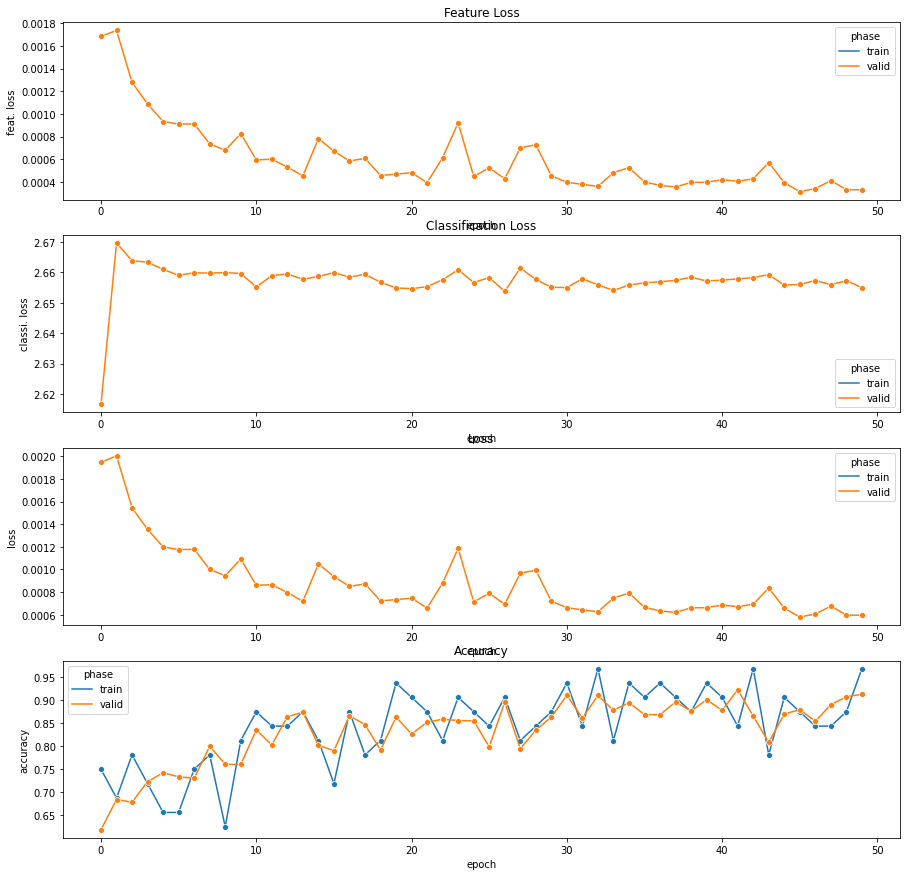

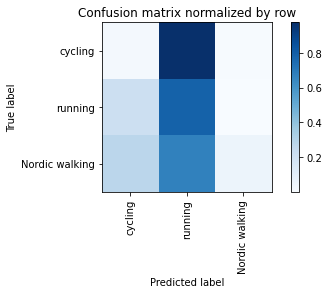

Overall accuracy: 0.199

                 precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

Nordic walking       0.898      0.053      0.100      0.419       1838|	 running: 0.669,	cycling: 0.279,	
       cycling       0.040      0.019      0.026      0.365       1600|	 running: 0.975,	Nordic walking: 0.006,	
       running       0.211      0.786      0.332      0.216        946|	 cycling: 0.212,	Nordic walking: 0.001,	

----------------------------------------------------------------------------------------------------
   avg / total       0.437      0.199      0.123        1.0       4384|	      

{'accuracy': 0.19867700729927007, 'precision': 0.3830369676947994, 'recall': 0.2859980332591804, 'f1': 0.15250562752652588, 'samples': 4384, 'loss': 58.616782918572426, 'feat. loss': 58.13221684098244, 'classi. loss': 4845.660598754883}
================ Fold-4 ================
Unseen Classes : ['ironing', 'car driving', 'folding laundry']
seen classes >  [0, 1, 2, 3, 4

Training Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/638 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

Overall accuracy: 0.742



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/638 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

Overall accuracy: 0.715



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/638 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

Overall accuracy: 0.709



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/638 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

Overall accuracy: 0.774



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/638 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

Overall accuracy: 0.817



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/638 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

Overall accuracy: 0.896



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/638 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

Overall accuracy: 0.820



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/638 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

Overall accuracy: 0.868



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/638 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

Overall accuracy: 0.882



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/638 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

Overall accuracy: 0.885



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/638 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

Overall accuracy: 0.760



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/638 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

Overall accuracy: 0.798



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/638 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

Overall accuracy: 0.913



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/638 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

Overall accuracy: 0.917



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/638 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

Overall accuracy: 0.909



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/638 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

Overall accuracy: 0.930



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/638 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

Overall accuracy: 0.923



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/638 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

Overall accuracy: 0.850



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/638 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

Overall accuracy: 0.917



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/638 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

Overall accuracy: 0.822



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/638 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

Overall accuracy: 0.924



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/638 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

Overall accuracy: 0.877



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/638 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

Overall accuracy: 0.919



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/638 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

Overall accuracy: 0.906



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/638 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

Overall accuracy: 0.903



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/638 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

Overall accuracy: 0.917



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/638 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

Overall accuracy: 0.907



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/638 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

Overall accuracy: 0.922



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/638 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

Overall accuracy: 0.909



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/638 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

Overall accuracy: 0.897



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/638 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

Overall accuracy: 0.929



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/638 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

Overall accuracy: 0.887



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/638 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

Overall accuracy: 0.912



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/638 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

Overall accuracy: 0.871



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/638 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

Overall accuracy: 0.863



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/638 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

Overall accuracy: 0.907



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/638 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

Overall accuracy: 0.933



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/638 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

Overall accuracy: 0.924



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/638 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

Overall accuracy: 0.916



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/638 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

Overall accuracy: 0.924



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/638 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

Overall accuracy: 0.933



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/638 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

Overall accuracy: 0.937



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/638 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

Overall accuracy: 0.934



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/638 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

Overall accuracy: 0.870



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/638 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

Overall accuracy: 0.933



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/638 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

Overall accuracy: 0.924



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/638 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

Overall accuracy: 0.910



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/638 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

Overall accuracy: 0.941



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/638 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

Overall accuracy: 0.942



sematic space generation:   0%|          | 0/23 [00:00<?, ?batch/s]

train:   0%|          | 0/638 [00:00<?, ?batch/s]

seen:   0%|          | 0/70 [00:00<?, ?batch/s]

Overall accuracy: 0.946



unseen:   0%|          | 0/120 [00:00<?, ?batch/s]

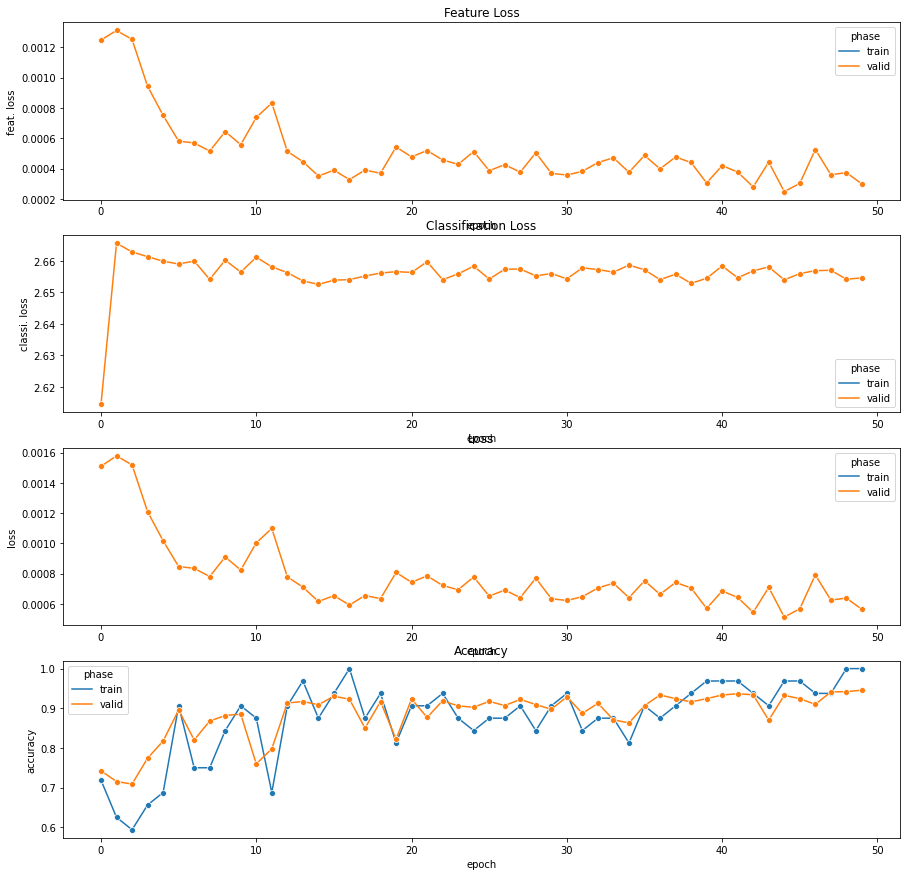

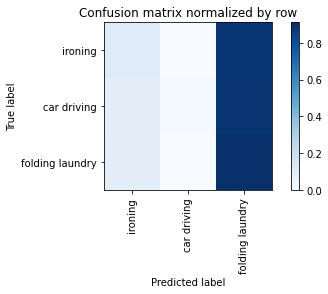

Overall accuracy: 0.299

                  precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

        ironing       0.656      0.110      0.189      0.607       2330|	 folding laundry: 0.890,	car driving: 0.000,	
folding laundry       0.257      0.912      0.402      0.253        972|	 ironing: 0.088,	car driving: 0.000,	
    car driving       1.000      0.013      0.026      0.140        538|	 folding laundry: 0.896,	ironing: 0.091,	

----------------------------------------------------------------------------------------------------
    avg / total       0.603      0.299      0.220        1.0       3840|	      

{'accuracy': 0.2994791666666667, 'precision': 0.6376985115464379, 'recall': 0.34494473844858736, 'f1': 0.20535357221398143, 'samples': 3840, 'loss': 56.374106392264366, 'feat. loss': 55.96538633108139, 'classi. loss': 4087.205310821533}
============== Overall Unseen Classes Performance ==============
accuracy           0.201870
precision          0.34375

In [24]:
run['parameters'] = config
fold_metric_scores = []

print("Generate Video Data ...")
video_transforms = transforms.Compose([CenterCrop(224)])
video_data = CollectedDataset(config["I3D"]["VID_LOC"],video_transforms,device)
video_dl = torch.utils.data.DataLoader(video_data, batch_size=config["I3D"]["batch_size"], shuffle=True, num_workers=1, pin_memory=True)

for i, cs in enumerate(fold_cls_ids):
    print("="*16, f'Fold-{i}', "="*16)
    print(f'Unseen Classes : {fold_classes[i]}')

    data_dict = dataReader.generate(unseen_classes=cs, seen_ratio=config['seen_split'], unseen_ratio=0.8, window_size=config['window_size'], window_overlap=config['overlap'], resample_freq=config['freq'])
    all_classes = dataReader.idToLabel
    seen_classes = data_dict['seen_classes']
    unseen_classes = data_dict['unseen_classes']
    print("seen classes > ", seen_classes)
    print("unseen classes > ", unseen_classes)
    train_n, seq_len, in_ft = data_dict['train']['X'].shape

    print("Initiate IMU datasets ...")
    # build IMU datasets
    train_dt = PAMAP2Dataset(data=data_dict['train']['X'], actions=data_dict['train']['y'], action_classes=seen_classes, seq_len=100)
    train_dl = DataLoader(train_dt, batch_size=config['batch_size'], shuffle=True, pin_memory=True, drop_last=True)
    # build seen eval_dt
    eval_dt = PAMAP2Dataset(data=data_dict['eval-seen']['X'], actions=data_dict['eval-seen']['y'], action_classes=seen_classes, seq_len=100)
    eval_dl = DataLoader(eval_dt, batch_size=config['batch_size'], shuffle=True, pin_memory=True, drop_last=True)
    # build unseen test_dt
    test_dt = PAMAP2Dataset(data=data_dict['test']['X'], actions=data_dict['test']['y'], action_classes=unseen_classes, seq_len=100)
    test_dl = DataLoader(test_dt, batch_size=config['batch_size'], shuffle=True, pin_memory=True, drop_last=True)
    
    # build model
    model = create_model(config,in_ft,seq_len,seen_classes)
    model.to(device)

    # define run parameters 
    optimizer = Adam(model.parameters(), lr=config['lr'], weight_decay=1e-5)
    loss_module = {'class': nn.CrossEntropyLoss(reduction="sum"), 'feature': shuffledTripletLoss}
    best_acc = 0.0

    # train the model 
    train_data = []
    for epoch in tqdm(range(config['n_epochs']), desc='Training Epoch', leave=False):
        #Generate Sementic spaces
        semantic_class,semantic_space = semantic_space_generation_step(model.video_encoder,video_dl,video_data, mode=config['feat_size'])
        
        # re-arrange semantic space
        activity_dict = dict(zip(semantic_class,semantic_space))
        semantic_space = np.array([activity_dict[c] for c in actionList])
        semantic_space = torch.from_numpy(semantic_space).to(device)

        train_metrics = train_step(model, 
                                   train_dl, 
                                   train_dt,
                                   semantic_space,
                                   optimizer, 
                                   loss_module, 
                                   device, 
                                   class_names=[all_classes[i] for i in seen_classes], 
                                   phase='train', 
                                   loss_alpha=0.0001)
        train_metrics['epoch'] = epoch
        train_metrics['phase'] = 'train'
        train_data.append(train_metrics)
        log(i, 'train', train_metrics)

        eval_metrics = eval_step(model, 
                                 eval_dl, 
                                 eval_dt,
                                 semantic_space,
                                 loss_module, 
                                 device, 
                                 class_names=[all_classes[i] for i in seen_classes], 
                                 phase='seen', 
                                 loss_alpha=0.0001, 
                                 print_report=False, 
                                 show_plot=False)
        eval_metrics['epoch'] = epoch 
        eval_metrics['phase'] = 'valid'
        train_data.append(eval_metrics)
        log(i, 'valid', train_metrics)
        # print(f"EPOCH [{epoch}] TRAINING : {train_metrics}")
        # print(f"EPOCH [{epoch}] EVAL : {eval_metrics}")
        if eval_metrics['accuracy'] > best_acc:
            best_model = deepcopy(model.state_dict())
    
    train_df = pd.DataFrame().from_records(train_data)
    plot_curves(train_df)

    # replace by best model 
    model.load_state_dict(best_model)
    # save_model(model,notebook_iden,model_iden,i)

    # run evaluation on unseen classes
    test_metrics = eval_step(model, 
                             test_dl,
                             test_dt,
                             semantic_space,
                             loss_module, 
                             device, 
                             class_names=[all_classes[i] for i in unseen_classes], 
                             phase='unseen', 
                             loss_alpha=0.0001, 
                             print_report=True, 
                             show_plot=True)
    fold_metric_scores.append(test_metrics)
    log('test', i, test_metrics)
    print(test_metrics)
    print("="*40)

print("="*14, "Overall Unseen Classes Performance", "="*14)
seen_score_df = pd.DataFrame.from_records(fold_metric_scores)
print(seen_score_df.mean())
log('global', '',seen_score_df.mean().to_dict())
run.stop()
